# OCR

(note: Images in original dataset are mostly very blurry, so we did OCR on pictures we took by ourselves and on No Parking sign only. )

Summery of OCR results:
* Tesseract is very easy to use, but doesn't give a good result, at its best it can only recognize some texts in an image and a lot of the recognition results are wrong, sometimes it can't recognize any texts at all.
* EasyOCR is relatively easy to use as well and it gives a fairly good result after we do some image processing (e.g. turn the image into grayscale)
* Google Vision API gives the most accurate result, but it is a paid service and it doesn't do text detection
* MMOCR is the most perfect for the purpose of this project, it does both text area detection and text recognition/interpretation, but we were unsuccessful in terms of combining text area detection and text recognition together

## Prepare Images for OCR

### Pre-processed Images

In [5]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt 

def read_image(path):
    img = cv2.imread(str(path))
    if img is None:
        return None
    else:
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

PATH = Path("./orig_new_images")
list(PATH.iterdir())[:5]

[PosixPath('orig_new_images/PXL_20240502_004006796.jpg'),
 PosixPath('orig_new_images/PXL_20240502_004331747.jpg'),
 PosixPath('orig_new_images/PXL_20240502_004226950.jpg'),
 PosixPath('orig_new_images/PXL_20240502_011607510.jpg'),
 PosixPath('orig_new_images/PXL_20240502_004445505.jpg')]

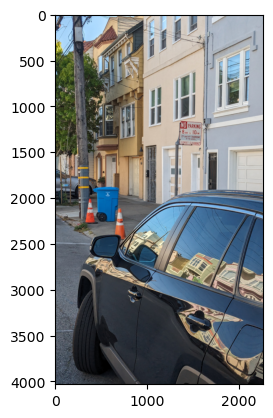

In [6]:
path = PATH/'PXL_20240502_004414444.jpg'
img = read_image(path)
plt.imshow(img)

### Processing Images

Here's the preprocessing we did for the images:
* Label them in label studio (add bounding boxes around No Parking sign and Mark them as No Parking sign)
* Randomly crop from original images to make sure parking signs is placed at random location on the image
* Turn cropped images into uniform size (1050 * 1050)

In [14]:
import os
from PIL import Image
import random

def read_yolo_bbox(bbox_data, img_width, img_height):
    class_id, x_center, y_center, width, height = map(float, bbox_data.split())
    width *= img_width
    height *= img_height
    x_center *= img_width
    y_center *= img_height
    x_min = int(x_center - width / 2)
    y_min = int(y_center - height / 2)
    x_max = int(x_center + width / 2)
    y_max = int(y_center + height / 2)
    return class_id, (x_min, y_min, x_max, y_max)

def ensure_within_bounds(min_val, max_val, dimension):
    if min_val > max_val:
        if min_val >= dimension:
            min_val = dimension - 1050
        max_val = min_val + (1050 if (min_val + 1050 <= dimension) else dimension - min_val)
    return max(0, min_val), min(max_val, dimension - 1050)

def random_crop_to_include_bboxes(image, bboxes, target_size=(1050, 1050)):
    img_width, img_height = image.size
    x_min = min(bbox[0] for _, bbox in bboxes)
    y_min = min(bbox[1] for _, bbox in bboxes)
    x_max = max(bbox[2] for _, bbox in bboxes)
    y_max = max(bbox[3] for _, bbox in bboxes)

    # Calculate the possible range for the top-left corner of the crop
    x_start_min = max(0, x_max - target_size[0])
    x_start_max = min(x_min, img_width - target_size[0])
    y_start_min = max(0, y_max - target_size[1])
    y_start_max = min(y_min, img_height - target_size[1])

    x_start_min, x_start_max = ensure_within_bounds(x_start_min, x_start_max, img_width)
    y_start_min, y_start_max = ensure_within_bounds(y_start_min, y_start_max, img_height)

    x_start = random.randint(x_start_min, x_start_max) if x_start_max >= x_start_min else x_start_min
    y_start = random.randint(y_start_min, y_start_max) if y_start_max >= y_start_min else y_start_min

    crop_box = (x_start, y_start, x_start + target_size[0], y_start + target_size[1])

    cropped_bboxes = []
    for class_id, bbox in bboxes:
        new_bbox = (
            max(0, bbox[0] - x_start), 
            max(0, bbox[1] - y_start), 
            max(0, bbox[2] - x_start), 
            max(0, bbox[3] - y_start)
        )
        cropped_bboxes.append((class_id, new_bbox))

    return image.crop(crop_box), cropped_bboxes


def save_cropped_data(cropped_image, cropped_bboxes, image_path, annotation_path):
    cropped_image.save(image_path)
    with open(annotation_path, 'w') as file:
        for class_id, (x_min, y_min, x_max, y_max) in cropped_bboxes:
            bbox_width = x_max - x_min
            bbox_height = y_max - y_min
            x_center = x_min + bbox_width / 2.0
            y_center = y_min + bbox_height / 2.0
            norm_width = bbox_width / 1050
            norm_height = bbox_height / 1050
            x_center /= 1050
            y_center /= 1050
            file.write(f"{int(class_id)} {x_center} {y_center} {norm_width} {norm_height}\n")

def process_images(images_folder, annotations_folder, save_folder):
    os.makedirs(os.path.join(save_folder, 'images'), exist_ok=True)
    os.makedirs(os.path.join(save_folder, 'labels'), exist_ok=True)

    for filename in os.listdir(images_folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(images_folder, filename)
            annotation_path = os.path.join(annotations_folder, os.path.splitext(filename)[0] + '.txt')
            save_image_path = os.path.join(save_folder, 'images', filename)
            save_annotation_path = os.path.join(save_folder, 'labels', os.path.splitext(filename)[0] + '.txt')
            
            with Image.open(img_path) as img:
                with open(annotation_path, 'r') as file:
                    bboxes = [read_yolo_bbox(line, img.width, img.height) for line in file.readlines()]
                    cropped_image, cropped_bboxes = random_crop_to_include_bboxes(img, bboxes)
                    save_cropped_data(cropped_image, cropped_bboxes, save_image_path, save_annotation_path)


images_folder = './new_images/images'
annotations_folder = './new_images/labels'
save_folder = './new_dataset'

process_images(images_folder, annotations_folder, save_folder)

### Post-processed Images

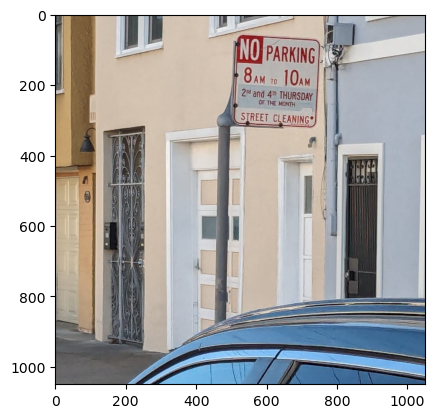

In [8]:
PATH = Path("./new_dataset/images")
path = PATH/'PXL_20240502_004414444.jpg'
img = read_image(path)
plt.imshow(img)

## Tesseract

In [13]:
import pytesseract
from PIL import Image

def extract_text_from_bboxes(image_path, annotation_path):
    """ Extract text from regions defined in the YOLO annotation file. """
    img = Image.open(image_path)
    img_width, img_height = img.size
    texts = []

    with open(annotation_path, 'r') as file:
        for line in file:
            _, x_center, y_center, width, height = map(float, line.split())
            x_center *= img_width
            y_center *= img_height
            width *= img_width
            height *= img_height
            x_min = int(x_center - width / 2)
            y_min = int(y_center - height / 2)
            x_max = int(x_center + width / 2)
            y_max = int(y_center - height / 2 + height)
            
            # Crop the image to the bounding box
            cropped_img = img.crop((x_min, y_min, x_max, y_max))
            text = pytesseract.image_to_string(cropped_img, lang='eng')
            texts.append(text)
    
    return texts

# Example usage
image_path = './new_dataset/images/PXL_20240502_004006796.jpg'
annotation_path = './new_dataset/labels/PXL_20240502_004006796.txt'
texts = extract_text_from_bboxes(image_path, annotation_path)
print(texts)

['']


## EasyOCR

Using CPU. Note: This module is much faster with a GPU.


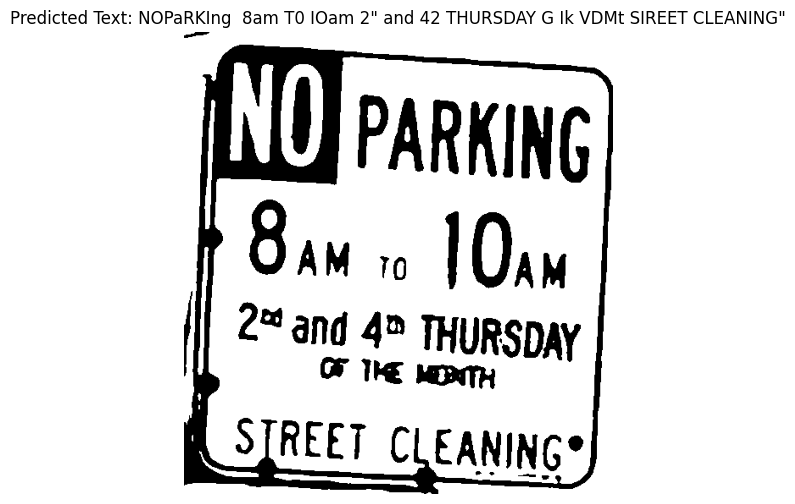

['NOPaRKIng  8am T0 IOam 2" and 42 THURSDAY G Ik VDMt SIREET CLEANING"']


In [70]:
import cv2
import numpy as np
import easyocr
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def preprocess_image_for_ocr(img_np):
    """ Apply preprocessing on the numpy image to enhance OCR results. """
    # Convert to grayscale
    gray = cv2.cvtColor(img_np, cv2.COLOR_BGR2GRAY)
    # Scale up the image
    gray = cv2.resize(gray, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    # Apply Gaussian Blur
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh

def extract_text_with_easyocr(image_path, annotation_path):
    """ Extract text from regions defined in the YOLO annotation file using EasyOCR. """
    reader = easyocr.Reader(['en'], gpu=False)
    img = Image.open(image_path)
    img_width, img_height = img.size
    texts = []

    with open(annotation_path, 'r') as file:
        for line in file:
            _, x_center, y_center, width, height = map(float, line.split())
            x_center *= img_width
            y_center *= img_height
            width *= img_width
            height *= img_height
            x_min = int(x_center - width / 2)
            y_min = int(y_center - height / 2)
            x_max = int(x_center + width / 2)
            y_max = int(y_center - height / 2 + height)
            
            # Crop the image to the bounding box
            cropped_img = img.crop((x_min, y_min, x_max, y_max))
            # Convert PIL Image to numpy array
            cropped_img_np = np.array(cropped_img)
            # Preprocess for OCR
            preprocessed_img = preprocess_image_for_ocr(cropped_img_np)
            # Convert back to PIL Image for display
            pil_img = Image.fromarray(preprocessed_img)
            # Perform OCR
            result = reader.readtext(preprocessed_img)
            if result:
                detected_text = " ".join([text for _, text, _ in result])
                texts.append(detected_text)
                display_image_with_text(pil_img, detected_text)
            else:
                texts.append("No text found")
                display_image_with_text(pil_img, "No text found")
    
    return texts

def display_image_with_text(image, text):
    """ Display the image with the predicted text. """
    plt.figure(figsize=(8, 6))
    plt.imshow(image, cmap='gray')
    plt.title(f"Predicted Text: {text}")
    plt.axis('off')
    plt.show()

# Example usage
image_path = '/Users/saad/Documents/GitHub/NoParkingAllowed/new_dataset/images/PXL_20240502_004414444.jpg'
annotation_path = '/Users/saad/Documents/GitHub/NoParkingAllowed/new_dataset/labels/PXL_20240502_004414444.txt'
texts = extract_text_with_easyocr(image_path, annotation_path)
print(texts)

## Google Vision API

In [12]:
from google.cloud import vision
from PIL import Image
import io

def extract_text_with_google_vision(image_path, annotation_path, credentials_path):
    """Extract text from regions defined in the YOLO annotation file using Google Vision API."""
    client = vision.ImageAnnotatorClient.from_service_account_json(credentials_path)
    img = Image.open(image_path)
    img_width, img_height = img.size
    texts = []

    with open(annotation_path, 'r') as file:
        for line in file:
            _, x_center, y_center, width, height = map(float, line.split())
            x_center *= img_width
            y_center *= img_height
            width *= img_width
            height *= img_height
            x_min = int(x_center - width / 2)
            y_min = int(y_center - height / 2)
            x_max = int(x_center + width / 2)
            y_max = int(y_center + height / 2)

            # Crop the image to the bounding box
            cropped_img = img.crop((x_min, y_min, x_max, y_max))
            # Convert PIL Image to bytes
            byte_arr = io.BytesIO()
            cropped_img.save(byte_arr, format='PNG')
            image_content = byte_arr.getvalue()
            
            # Create an Image object for the Vision API
            image = vision.Image(content=image_content)
            # Perform text detection
            response = client.text_detection(image=image)
            annotations = response.text_annotations

            if annotations:
                detected_text = annotations[0].description.strip()
                texts.append(detected_text)
            else:
                texts.append("No text found")

            if response.error.message:
                raise Exception(f'{response.error.message}\nFor more info on error messages, check: https://cloud.google.com/apis/design/errors')

    return texts

# Example usage
image_path = './new_dataset/images/PXL_20240502_004414444.jpg'
annotation_path = './new_dataset/labels/PXL_20240502_004414444.txt'
credentials_path = './cedar-module-423218-u2-727606fb3ce5.json'
texts = extract_text_with_google_vision(image_path, annotation_path, credentials_path)
print(texts)

['NO PARKING\n8AM TO 10AM\n2nd and 4th THURSDAY\nOF THE MONTH\nSTREET CLEANING']


## MMOCR

In [51]:
from mmocr.apis import MMOCRInferencer

kie = MMOCRInferencer(det='w', rec='ABINet')
kie('./new_dataset/images/PXL_20240502_004414444.jpg', show=True)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textdet/dbnetpp/dbnetpp_resnet50-oclip_fpnc_1200e_icdar2015/dbnetpp_resnet50-oclip_fpnc_1200e_icdar2015_20221101_124139-4ecb39ac.pth
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/abinet/abinet_20e_st-an_mj/abinet_20e_st-an_mj_20221005_012617-ead8c139.pth


Output()

The model and loaded state dict do not match exactly

unexpected key in source state_dict: data_preprocessor.mean, data_preprocessor.std



{'predictions': [{'rec_texts': ['au',
    'as',
    'cleaning',
    'street',
    'mon',
    '11',
    'thursday',
    'and',
    '24',
    '10am',
    '8am',
    'parking',
    'no'],
   'rec_scores': [0.19111628830432892,
    0.27552006393671036,
    0.9999988228082657,
    0.9999717076619467,
    0.5232564310232798,
    0.5074829906225204,
    0.9999956637620926,
    0.9999586741129557,
    0.6771517395973206,
    0.9674001932144165,
    0.967011034488678,
    0.9993438294955662,
    0.9999867677688599],
   'det_polygons': [[816.7835265398026,
     867.6678478717804,
     817.970260977745,
     851.0534405708313,
     852.656552195549,
     853.5310506820679,
     851.4698177576065,
     870.145457983017],
    [850.6641626358032,
     862.1484875679016,
     857.8418970108032,
     847.7930188179016,
     875.8887469768524,
     856.8165063858032,
     868.7110126018524,
     871.1719751358032],
    [588.5514378547668,
     735.7567638158798,
     590.1413440704346,
     711.5892380

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textdet/dbnetpp/dbnetpp_resnet50-oclip_fpnc_1200e_icdar2015/dbnetpp_resnet50-oclip_fpnc_1200e_icdar2015_20221101_124139-4ecb39ac.pth


Output()

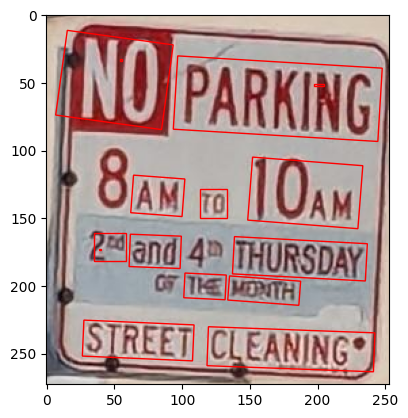

In [73]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_detected_boxes(cropped_images, results):
    for img, result in zip(cropped_images, results):
        fig, ax = plt.subplots(1)
        ax.imshow(img)
        for box in result['polygons']:
            # Convert the polygon into a format matplotlib can use
            poly = np.array(box).reshape((4, 2))
            # Create a polygon patch and add it to the axes
            polygon = patches.Polygon(poly, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(polygon)
        plt.show()

from mmocr.apis import TextDetInferencer
import cv2
import numpy as np
from PIL import Image

def extract_text_with_mmocr(image_path, annotation_path):
    """Extract text using MMOCR from regions defined in the YOLO annotation file with preprocessing."""
    inferencer = TextDetInferencer(model='DBNetpp', )
    img = Image.open(image_path)
    img_width, img_height = img.size
    cropped_images = []
    results = []

    with open(annotation_path, 'r') as file:
        for line in file:
            _, x_center, y_center, width, height = map(float, line.split())
            x_center *= img_width
            y_center *= img_height
            width *= img_width
            height *= img_height
            x_min = int(x_center - width / 2)
            y_min = int(y_center - height / 2)
            x_max = int(x_center + width / 2)
            y_max = int(y_center + height / 2)

            # Crop the image to the bounding box
            cropped_img = img.crop((x_min, y_min, x_max, y_max))
            cropped_img_np = np.array(cropped_img)

            # Preprocess the image
            processed_img_np = preprocess_image_for_ocr(cropped_img_np)

            # Perform text detection using MMOCR
            result = inferencer(cropped_img_np)
            if result:
                results.extend(result['predictions'])  # Correctly extend the results list with predictions
            cropped_images.append(cropped_img_np)

    return cropped_images, results

# Example usage
image_path = 'w'
annotation_path = './new_dataset/labels/PXL_20240502_004414444.txt'
cropped_images, detected_results = extract_text_with_mmocr(image_path, annotation_path)
show_detected_boxes(cropped_images, detected_results)
